# Промышленность — описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

- **Задача** — построить модель, которая будет предсказывать температуру стали (задача регрессии).  
- **Метрика** -  Значение метрики MAE у выбранной модели должно быть менее 6.8.


**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав, добавляя куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).  

***Описание данных:***

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- `data_arc` — данные об электродах;
- `data_bulk` — данные об объёме сыпучих материалов;
- `data_bulk_time` — данные о времени подачи сыпучих материалов;
- `data_gas` — данные о продувке сплава газом;
- `data_temp` — данные об измерениях температуры;
- `data_wire` — данные об объёме проволочных материалов;
- `data_wire_time` — данные о времени подачи проволочных материалов.

    **Таблица** `data_arc`

    - `key` — номер партии;
    - `BeginHeat` — время начала нагрева;
    - `EndHeat` — время окончания нагрева;
    - `ActivePower` — значение активной мощности;
    - `ReactivePower` — значение реактивной мощности.

  **Таблица** `data_bulk`

    - `key` — номер партии;
    - `Bulk1` … `Bulk15` — объём подаваемого материала.

  **Таблица** `data_bulk_time`

    - `key` — номер партии;
    - `Bulk1` … `Bulk15` — время подачи материала.

  **Таблица** `data_gas`

    - `key` — номер партии;
    - `gas` — объём подаваемого газа.

  **Таблица** `data_temp`

    - `key` — номер партии;
    - `MesaureTime` — время замера;
    - `Temperature` — значение температуры.

  **Таблица** `data_wire`

    - `key` — номер партии;
    - `Wire1` … `Wire15` — объём подаваемых проволочных материалов.

  **Таблица** `data_wire_time`

    - `key` — номер партии;
    - `Wire1` … `Wire15` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

***План работы:***

1. Загрузка данных.
2. Исследовательский анализ и предобработка данных.
3. Обучение моделей.
4. Тестирование выбранной модели.
5. Вывод.

## Загрузка данных

In [1]:
#!pip install shap

In [2]:
# Импорт библиотек:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import shap
import torch
import torch.nn as nn



from sqlalchemy import create_engine, inspect
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter('ignore', FutureWarning)

In [3]:
HOME_PATH = r'C:\Users\Oz\Downloads\ds-plus-final.db'
SERVE_PATH = 'ds-plus-final.db'

RANDOM_STATE = 12082024

In [4]:
# Проверка доступа к базе данных:
if os.path.exists(HOME_PATH): # домашняя версия
    path_to_db = HOME_PATH
elif os.path.exists(SERVE_PATH): # сетевая версия
    path_to_db = SERVE_PATH
else:
    raise SystemError('Что-то пошло не так.') # обработка ошибки

In [5]:
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

print(inspect(engine).get_table_names())

['contract', 'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time', 'internet', 'personal', 'phone']


***Вывод:***  
В базе данных присутствуют нужные таблицы.

## Исследовательский анализ и предобработка данных.

### Таблица данных об электродах

**Таблица** `data_arc`
  - `key` — номер партии;
  - `BeginHeat` — время начала нагрева;
  - `EndHeat` — время окончания нагрева;
  - `ActivePower` — значение активной мощности;
  - `ReactivePower` — значение реактивной мощности.

In [6]:
query = '''

SELECT *
FROM data_arc

'''

data_arc = pd.read_sql_query(query, con=engine) 
display(data_arc)
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


- В датасете 14875 строк и 5 столбцов. Названия столбцов на разных языках.
- Неверный формат данных нагрева дугой.
- Пропусков нет.

Приведем названия столбцов в соответствие с PEP8, преобразуем поля с датой и временем в формат datetime:

In [7]:
data_arc.columns=['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power']

data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'])
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'])

data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [8]:
data_arc.describe(include='all')

,key,begin_heat,end_heat,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-05-26 01:40:30,2019-05-23 10:08:42,NaN,NaN
freq,NaN,1,1,NaN,NaN
first,NaN,2019-05-03 11:02:14,2019-05-03 11:06:02,NaN,NaN
last,NaN,2019-09-06 17:24:54,2019-09-06 17:26:15,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175


In [9]:
print('Среднее количество обработок для одной партии:', (data_arc['key'].count() / data_arc['key'].nunique()).round(2))

Среднее количество обработок для одной партии: 4.63


In [10]:
# Распределение партий по количеству обработок:
data_arc.groupby('key')['key'].count().value_counts()

4     892
5     759
3     520
6     490
7     205
2     174
8      84
1      39
9      28
10      9
11      5
12      3
13      2
15      2
14      1
16      1
Name: key, dtype: int64

Время окончания процесса должно быть больше времени начала.

In [11]:
(data_arc['end_heat'] -  data_arc['begin_heat']).describe()

count                        14876
mean     0 days 00:02:51.670946490
std      0 days 00:01:38.186802680
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
dtype: object

In [12]:
# контроль неэффективной работы
print('Активная мощность меньше реактивной:')
display(data_arc[data_arc['active_power'] < data_arc['reactive_power']])

Активная мощность меньше реактивной:


,key,begin_heat,end_heat,active_power,reactive_power


- Датасет содержит 14 876 записей, пропусков нет;
- Всего в данных об электродах содержится информация о 3214 партиях, каждая партия подвергается обработке в среднем 4,6 раза;
- Каждая партия подвергается обработке от одного до 16 раз, в основном обрабатываются по 4-5 раз, доля таких партий превышает половину всего количества партий в имеющихся данных, менее 2 и более 7 раз подвергаются обработке сравнительно небольшая доля партий стали;
- В данных содержится информация с 03 марта по 06 сентября 2019 года;
- В среднем процесс длится около 3 минут, минимальная продолжительность обработки составляет 11 секунд, максимальная - чуть больше 15 минут;
- В столбце с реактивной мощностью имеются отрицательные значений.

Посмотрим записи с отрицательной реактивной мощностью:

In [13]:
data_arc.query('reactive_power <= 0')

,key,begin_heat,end_heat,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Реактивная мощность может иметь отрицательное значение. Такое значение для имеющихся данных имеет нехарактерно высокое значение по модулю, что свидетельствует о некорректности этого значения. Посмотрим единичная это партия или нет для определения можно ли его исключить.

In [14]:
data_arc[data_arc['key'] == 2116]

,key,begin_heat,end_heat,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Попробуем спасти партию № 2116.  
Для корректной замены рассчитаем корреляцию между активной и реактивной мощностью, исключив данное значение

In [15]:
data_arc.query('index != 9780')[['active_power', 'reactive_power']].corr()

,active_power,reactive_power
active_power,1.000000,0.966373
reactive_power,0.966373,1.000000


Между активной и реактивной мощностью высокая положительная корреляция

In [16]:
(data_arc.query('index != 9780')['reactive_power'] / data_arc.query('index != 9780')['active_power']).median().round(2)

0.72

Реактивная мощность составляет в среднем 0,72 от активной, используем данное значение для замены

In [17]:
data_arc.loc[data_arc['reactive_power'] < 0, 'reactive_power'] = data_arc['active_power'] * 0.72

In [18]:
data_arc[data_arc['key'] == 2116]

,key,begin_heat,end_heat,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.507848
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Посмотрим на распределение данных

In [19]:
# plt.figure(figsize=(15,8))
# plt.subplot(2,1,1)
# sns.histplot(data=data_arc[['active_power', 'reactive_power']])
# plt.title('Распределение мощностей по партиям')
# plt.xlabel('Значение мощности, ватт')
# plt.ylabel('Кол-во измерений')
# plt.grid()
# plt.subplot(2,1,2)
# sns.boxplot(data=data_arc[['active_power', 'reactive_power']], orient='horizontal')
# plt.grid()
# plt.show()

Явных выбросов в значениях мощностей нет.

Добавим в таблицу общее время нагрева в секундах:

In [20]:
data_arc['heat_time'] = (data_arc['end_heat'] -  data_arc['begin_heat']).dt.total_seconds()

Добавим столбцы, содержащие в себе полную мощность и коэффициент мощности(отношение активной мощности P к полной мощности S) по формулам:


$$
S = \sqrt{P^2 + Q^2}
$$

    
$$
λ = \frac{P}{S}
$$   

In [21]:
data_arc['total_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5 
data_arc['power_coef'] = data_arc['active_power'] / data_arc['total_power']

Агрегируем полученные данные по ключу. Оставим на данном этапе временную составляющую обработки электродами, взяв начальное время и конечное время обработки.

In [22]:
agg_func_arc = {
    'key'            : 'count', 
    'begin_heat'     : 'first',
    'end_heat'       : 'last',
    'active_power'   : 'sum',
    'reactive_power' : 'sum',
    'heat_time'      : 'sum',
    'total_power'    : 'sum',
    'power_coef'     : 'sum'
}

In [23]:
data_arc_gr = data_arc.groupby('key').agg(agg_func_arc).rename(columns={'key':'iter_num'})
data_arc_gr

,iter_num,begin_heat,end_heat,active_power,reactive_power,heat_time,total_power,power_coef
key,,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,3.036730,2.142821,1098.0,3.718736,4.083428
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,2.139408,1.453357,811.0,2.588349,3.301105
3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,4.063641,2.937457,655.0,5.019223,4.048621
4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,2.706489,2.056992,741.0,3.400038,3.175691
5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,2.252950,1.687991,869.0,2.816980,3.187274
...,...,...,...,...,...,...,...,...
3237,5,2019-09-06 11:31:25,2019-09-06 11:53:55,2.541872,2.025417,909.0,3.250657,3.915487
3238,3,2019-09-06 12:16:25,2019-09-06 12:31:35,1.374821,1.038103,546.0,1.723937,2.391324
3239,8,2019-09-06 14:17:00,2019-09-06 15:05:50,4.848005,3.541541,1216.0,6.014480,6.413809


***Вывод:***

- Всего в данных об электродах содержится информация о 3214 партиях, каждая партия подвергается обработке в среднем 4,6 раза;
- Привели названия столбцов к стандарту PEP8 и данные к соответствующему им типу; 
- Каждая партия подвергается обработке от одного до 16 раз, в основном обрабатываются по 4-5 раз, доля таких партий превышает половину всего количества партий в имеющихся данных, менее 2 и более 7 раз подвергаются обработке сравнительно небольшая доля партий стали;
- В данных содержится информация с 03 марта по 06 сентября 2019 года;
- В среднем процесс длится около 3 минут, минимальная продолжительность обработки составляет 11 секунд, максимальная - чуть больше 15 минут;
- В столбце с реактивной мощностью избавились от отрицательные значений заменив медианным;
- Добавили столбец продолжительности нагрева - `heat_time` и столбец кол-ва итераций в партии - `iter_num`.

### Таблица данных об объёме сыпучих материалов

**Таблица** `data_bulk`
   - `key` — номер партии;
   - `Bulk1` … `Bulk15` — объём подаваемого материала.

In [24]:
query = '''

SELECT *
FROM data_bulk

'''

data_bulk = pd.read_sql_query(query, con=engine) 
display(data_bulk)
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,None,None,None,None,None,None,None,252.0,None,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,None,None,None,None,None,None,None,254.0,None,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,None,114.0,None,None,None,None,None,158.0,None,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,None,26.0,None,None,None,None,None,None,None,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


- Датасет содержит 3129 записей (кол-во записей ниже кол-ва партий - 3241), присутствуют пропуски данных ввиде `Nan` и `None`;
- Столбцы имею некорректный тип данных `object` вместо `float`.

Приведем столбцы к корректному типу данных:

In [25]:
def columns(data):
    col = data.select_dtypes(include=['object']).columns
    data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [26]:
columns(data_bulk)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Приведем названия столбцов в соответствие с PEP8.

In [27]:
data_bulk.columns = [x.replace(' ','_').lower() for x in  data_bulk.columns]
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [28]:
print('Кол-во дубликатов:', data_bulk['key'].duplicated().sum())

Кол-во дубликатов: 0


In [29]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Материал № 8 был добавлен всего в одну партию. Наименьшее кол-во использований из оставшихся материалов  характерно для материалов № 2, 9 и 13, они добавлялись в 22, 19 и 17 партий стали соответственно. Явно ошибочных значений в представленной таблице нет. Минимальный объем добавок во всех случаях положителен, максимальные объемы для большинства добавок составляют от 185 до 636, для материала № 12 - максимальный объем составляет 1849, что выделяет его среди других значений.

Посмотрим, какую долю от общего числа составляют пропущенные значения:

In [30]:
data_bulk.isna().sum()/data_bulk.shape[0]

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

Уберем столбцы, где доля пропущенных значений более 80%:

In [31]:
cols = data_bulk.columns
for col in cols:
    if data_bulk[col].isna().sum()/data_bulk.shape[0] > 0.8:
        data_bulk = data_bulk.drop(col, axis=1)

Заменим пропуски на нули, тк пропуск обозначает, что материал не добавляли в эту партию.

In [32]:
data_bulk_gr = data_bulk.fillna(0).reset_index(drop=True)

In [33]:
data_bulk_gr

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0
...,...,...,...,...,...,...
3124,3237,170.0,0.0,252.0,130.0,206.0
3125,3238,126.0,0.0,254.0,108.0,106.0
3126,3239,0.0,0.0,158.0,270.0,88.0
3127,3240,0.0,0.0,0.0,192.0,54.0


***Вывод:***
- Датасет содержит 3129 записей (кол-во записей ниже кол-ва партий - 3241);
- Привели названия столбцов к стандарту PEP8 и данные к соответствующему им типу;
- Материал № 8 был добавлен всего в одну партию. Наименьшее кол-во использований из оставшихся материалов  характерно для материалов № 2, 9 и 13, они добавлялись в 22, 19 и 17 партий стали соответственно. Явно ошибочных значений в представленной таблице нет. Минимальный объем добавок во всех случаях положителен, максимальные объемы для большинства добавок составляют от 185 до 636, для материала № 12 - максимальный объем составляет 1849, что выделяет его среди других значений;
- Избавились от столбцов с долей пропущенных значений > 80%.

### Таблица данных о времени подачи сыпучих материалов

**Таблица** `data_bulk_time`
   - `key` — номер партии;
   - `Bulk1` … `Bulk15` — время подачи материала.

In [34]:
query = '''

SELECT *
FROM data_bulk_time

'''

data_bulk_time = pd.read_sql_query(query, con=engine) 
display(data_bulk_time)
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,None,None,2019-09-06 11:54:15,None,None,None,None,None,None,None,None,2019-09-06 11:49:45,None,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,None,None,2019-09-06 12:26:52,None,None,None,None,None,None,None,None,2019-09-06 12:18:35,None,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,None,None,None,None,None,2019-09-06 15:06:00,None,None,None,None,None,2019-09-06 15:01:44,None,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,None,None,None,None,None,2019-09-06 16:24:28,None,None,None,None,None,None,None,2019-09-06 16:07:29,2019-09-06 16:01:34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


- Датасет содержит 3129 записей (кол-во записей ниже кол-ва партий - 3241), присутствуют пропуски данных ввиде `None`;
- Столбцы имею некорректный тип данных `object` вместо `datetime`.

Приведем названия столбцов в соответствие с PEP8.

In [35]:
data_bulk_time.columns = [x.replace(' ','_').lower() for x in  data_bulk_time.columns]
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [36]:
print('Кол-во дубликатов:', data_bulk_time['key'].duplicated().sum())

Кол-во дубликатов: 0


Преобразуем время в формат datetime:

In [37]:
data_bulk_time = data_bulk_time.set_index('key')

In [38]:
for i in range(1,16):
    data_bulk_time['bulk_' + str(i)] = pd.to_datetime(data_bulk_time['bulk_' + str(i)])

In [39]:
data_bulk_time.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Произведем рассчет столбцов с временем начала добавления сыпучих материалов, окончания и длительности процесса:

In [40]:
data_bulk_time['begin_time_bulk'] = data_bulk_time.min(axis=1)
data_bulk_time['end_time_bulk'] = data_bulk_time.max(axis=1)
data_bulk_time['duration_bulk_time'] = (data_bulk_time['end_time_bulk'] - data_bulk_time['begin_time_bulk']).astype('timedelta64[s]')

Оставим только рассчитанные столбцы:

In [41]:
data_bulk_time = data_bulk_time[['begin_time_bulk', 'end_time_bulk','duration_bulk_time']]

In [42]:
data_bulk_time.describe()

,duration_bulk_time
count,3129.000000
mean,964.906679
std,798.088025
min,0.000000
25%,485.000000
50%,877.000000
75%,1311.000000
max,13683.000000


In [43]:
data_bulk_time.describe(include='datetime')

,begin_time_bulk,end_time_bulk
count,3129,3129
unique,3129,3129
top,2019-07-04 10:16:10,2019-08-28 20:35:53
freq,1,1
first,2019-05-03 11:10:43,2019-05-03 11:28:48
last,2019-09-06 17:23:15,2019-09-06 17:26:33


Время добавления сыпучих материалов находится в тех же промежутках, что и ранее рассмотренные данные по обработке стали. Длительность обработок с использованием сыпучих материалов выглядят корректным, максимальная длительность обработки одной партии составляет 13683 сек (почти 4 часа)

Данные по времени подачи сыпучих материалов можно не использовать. Такие данные нужны, чтобы подтвердить, что технологический процесс выполняется корректно и по времени.

***Вывод:***
- Датасет содержит 3129 записей (кол-во записей ниже кол-ва партий - 3241);
- Проведен анализ времени добавления сыпучих материалов. Время добавления сыпучих материалов находится в тех же промежутках, что и ранее рассмотренные данные по обработке стали;
- Данные о времени подачи сыпучих материалов были нужны для подтверждения корректности тех. процесса по времени.

### Таблица данных о продувке сплава газом

**Таблица** `data_gas`
   - `key` — номер партии;
   - `gas` — объём подаваемого газа.

In [44]:
query = '''

SELECT *
FROM data_gas

'''

data_gas = pd.read_sql_query(query, con=engine) 
display(data_gas)
data_gas.info()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


- Датасет содержит 3238 записей (кол-во записей ниже кол-ва партий - 3241), пропуски отсутствуют.

Приведем названия столбцов в соответствие с PEP8.

In [45]:
data_gas_gr = data_gas.rename(columns={'Газ 1':'gas'})

data_gas_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [46]:
print('Кол-во дубликатов:', data_gas_gr['key'].duplicated().sum())

Кол-во дубликатов: 0


In [47]:
data_gas_gr.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Посмотрим на распределение данных

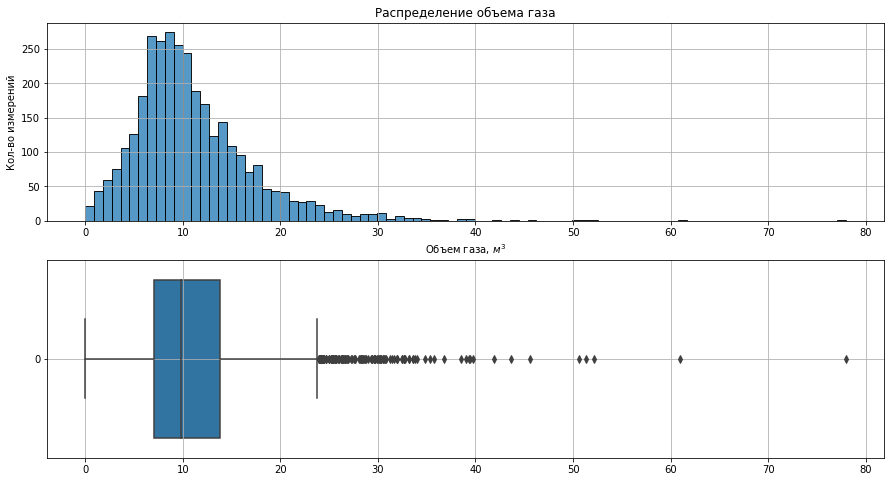

In [48]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.histplot(data=data_gas_gr['gas'])
plt.title('Распределение объема газа')
plt.xlabel('Объем газа, $м^3$')
plt.ylabel('Кол-во измерений')
plt.grid()
plt.subplot(2,1,2)
sns.boxplot(data=data_gas_gr['gas'], orient='horizontal')
plt.grid()
plt.show()

Объем подаваемого газа составляет в среднем 10 $м^3$, в некоторых случаях достигая 40-80 $м^3$. Т.к. на данном этапе нет информации о допустимых границах этого параметра технологическом процессе, оставим все имеющиеся значения без удаления.


***Вывод:***
- Датасет содержит 3238 записей (кол-во записей ниже кол-ва партий - 3241), пропуски отсутствут;
- Объем подаваемого газа составляет в среднем 10 $м^3$, в некоторых случаях достигая 40-80 $м^3$. Т.к. на данном этапе нет информации о допустимых границах этого параметра технологическом процессе, оставим все имеющиеся значения без удаления.

### Таблица данных об измерениях температуры

**Таблица** `data_temp`
   - `key` — номер партии;
   - `MesaureTime` — время замера;
   - `Temperature` — значение температуры.

- Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
- При агрегировании наблюдений используйте только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.
- Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.

In [49]:
query = '''

SELECT *
FROM data_temp

'''

data_temp = pd.read_sql_query(query, con=engine) 
display(data_temp)
data_temp.info()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,None
18088,3241,2019-09-06 17:06:38,None
18089,3241,2019-09-06 17:21:48,None
18090,3241,2019-09-06 17:24:44,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


- Датасет содержит 18092 записи в 3-х столбцах, присутствуют пропуски данных ввиде `None`;
- Столбцы с временем замера и температуры содержат некорректный тип данных.

Приведем названия столбцов в соответствие с PEP8, преобразуем поля с датой и временем в формат `datetime`, поле с значением температуры в формат `float`.

In [50]:
data_temp.columns=['key', 'mesaure_time', 'temperature']

In [51]:
data_temp['mesaure_time'] = pd.to_datetime(data_temp['mesaure_time'])

data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], errors='coerce')

In [52]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   mesaure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Заказчик предупредил, что значения температуры ниже 1500 °C — аномальные. Выберем только те данные которые свыше 1500 °C:

In [53]:
data_temp = data_temp.query('temperature >= 1500')
data_temp = data_temp.reset_index(drop=True)

In [54]:
data_temp.describe()

,key,temperature
count,14660.000000,14660.000000
mean,1325.369236,1590.852729
std,787.407873,19.143141
min,1.000000,1515.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1962.250000,1599.000000
max,3241.000000,1705.000000


In [55]:
data_temp

,key,mesaure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
14655,3237,2019-09-06 11:31:15,1569.0
14656,3238,2019-09-06 12:16:15,1584.0
14657,3239,2019-09-06 14:16:50,1598.0
14658,3240,2019-09-06 15:25:21,1617.0


Оставим партии, у которых как минимум два наблюдения: первый и последний замеры температуры, где последний замер является целевым признаком, для этого узнаем, сколько итераций приходится на каждую партию:

In [56]:
rm = data_temp.groupby('key').agg({'key':'count'}).rename(columns={'key':'iter_num'})

In [57]:
data_temp = data_temp.merge(rm, on='key')

data_temp

,key,mesaure_time,temperature,iter_num
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:07:18,1604.0,6
2,1,2019-05-03 11:11:34,1618.0,6
3,1,2019-05-03 11:18:04,1601.0,6
4,1,2019-05-03 11:25:59,1606.0,6
...,...,...,...,...
14655,3237,2019-09-06 11:31:15,1569.0,1
14656,3238,2019-09-06 12:16:15,1584.0,1
14657,3239,2019-09-06 14:16:50,1598.0,1
14658,3240,2019-09-06 15:25:21,1617.0,1


По условию задачи целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные. Поэтому для каждого ключа оставим только первую и последнюю температуру, а также время измерения и число итераций на каждом ключе.

Первую и последнюю температуры найдем по времени для каждого ключа.

In [58]:
data_temp_gr = data_temp.groupby('key')['mesaure_time'].agg(['first', 'last']).reset_index().rename(columns=
                                                            {'first':'start_time_temp','last':'finish_time_temp'})
data_temp_gr

,key,start_time_temp,finish_time_temp
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39
...,...,...,...
3210,3237,2019-09-06 11:31:15,2019-09-06 11:31:15
3211,3238,2019-09-06 12:16:15,2019-09-06 12:16:15
3212,3239,2019-09-06 14:16:50,2019-09-06 14:16:50
3213,3240,2019-09-06 15:25:21,2019-09-06 15:25:21


В датасете есть партии значения замера температуры для которой в начале и конце замера одно и тоже.

In [59]:
# Смотрим на записи:

data_temp_gr.query('start_time_temp == finish_time_temp')

,key,start_time_temp,finish_time_temp
192,195,2019-05-11 00:01:36,2019-05-11 00:01:36
276,279,2019-05-14 10:13:01,2019-05-14 10:13:01
2477,2500,2019-08-10 14:04:39,2019-08-10 14:04:39
2478,2501,2019-08-10 14:41:14,2019-08-10 14:41:14
2479,2502,2019-08-10 15:39:39,2019-08-10 15:39:39
...,...,...,...
3210,3237,2019-09-06 11:31:15,2019-09-06 11:31:15
3211,3238,2019-09-06 12:16:15,2019-09-06 12:16:15
3212,3239,2019-09-06 14:16:50,2019-09-06 14:16:50
3213,3240,2019-09-06 15:25:21,2019-09-06 15:25:21


In [60]:
# Распределение партий по количеству обработок:
data_temp.groupby('key')['key'].count().value_counts()

1     740
5     689
6     579
4     394
7     389
8     151
3     136
9      66
2      33
10     21
11      7
12      3
14      2
16      2
13      2
17      1
Name: key, dtype: int64

Соответственно значение длительности замера равно 0. Примечательно что это кол-во совпадает с кол-вом итераций в партиях равных 1. Всего таких записей/партий 740.
Эти данные не полные. Восстановить их нет возможности. Исключим их из датасета.

In [61]:
data_temp_gr = data_temp_gr.query('start_time_temp != finish_time_temp')

data_temp_gr

,key,start_time_temp,finish_time_temp
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39
...,...,...,...
2472,2495,2019-08-10 11:27:47,2019-08-10 11:50:47
2473,2496,2019-08-10 11:56:48,2019-08-10 12:25:13
2474,2497,2019-08-10 12:37:26,2019-08-10 12:53:28
2475,2498,2019-08-10 12:58:11,2019-08-10 13:23:31


In [62]:
# Объеденяемв общую таблицу:

data_temp_gr = data_temp_gr.merge(data_temp, left_on=['key', 'start_time_temp'], right_on=['key', 'mesaure_time']
                                 ).rename(columns={'temperature':'start_temp'})
data_temp_gr = data_temp_gr.merge(data_temp, left_on=['key', 'finish_time_temp'], right_on=['key', 'mesaure_time']
                                       ).rename(columns={'temperature':'finish_temp'})
data_temp_gr

,key,start_time_temp,finish_time_temp,mesaure_time_x,start_temp,iter_num_x,mesaure_time_y,finish_temp,iter_num_y
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,2019-05-03 11:02:04,1571.0,6,2019-05-03 11:30:38,1613.0,6
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,2019-05-03 11:34:04,1581.0,5,2019-05-03 11:55:09,1602.0,5
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,2019-05-03 12:06:44,1596.0,6,2019-05-03 12:35:57,1599.0,6
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,2019-05-03 12:39:27,1601.0,5,2019-05-03 12:59:47,1625.0,5
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,2019-05-03 13:11:03,1576.0,5,2019-05-03 13:36:39,1602.0,5
...,...,...,...,...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,2019-08-10 11:27:47,1570.0,5,2019-08-10 11:50:47,1591.0,5
2471,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,2019-08-10 11:56:48,1554.0,7,2019-08-10 12:25:13,1591.0,7
2472,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,2019-08-10 12:37:26,1571.0,4,2019-08-10 12:53:28,1589.0,4
2473,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,2019-08-10 12:58:11,1591.0,6,2019-08-10 13:23:31,1594.0,6


In [63]:
data_temp_gr['mesaure_time'] = (data_temp_gr['mesaure_time_y'] - data_temp_gr['mesaure_time_x']).dt.total_seconds()

data_temp_gr = data_temp_gr.drop(['mesaure_time_x', 'mesaure_time_y', 'iter_num_x'], axis=1)

data_temp_gr = data_temp_gr.set_index('key')

In [64]:
data_temp_gr

,start_time_temp,finish_time_temp,start_temp,finish_temp,iter_num_y,mesaure_time
key,,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,1714.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,1265.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,1753.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,1220.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,1536.0
...,...,...,...,...,...,...
2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,5,1380.0
2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,7,1705.0
2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,4,962.0


Посмотрим на распределение данных

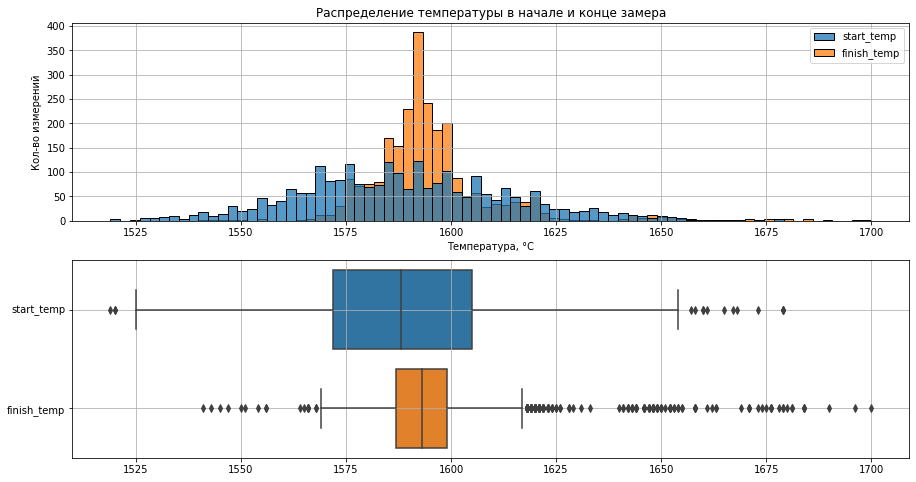

In [65]:
# Посмотрим на распределение температуры в начале и конце замера:

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.histplot(data=data_temp_gr[['start_temp', 'finish_temp']])
plt.title('Распределение температуры в начале и конце замера')
plt.xlabel('Температура, °C')
plt.ylabel('Кол-во измерений')
plt.grid()
plt.subplot(2,1,2)
sns.boxplot(data=data_temp_gr[['start_temp', 'finish_temp']], orient='horizontal')
plt.grid()
plt.show()

Распределение конечной температуры имеет меньшее отклонение и сосредоточено в районе 1560-1620 град. Начальная температура имеет более широкий диапазон изменений.

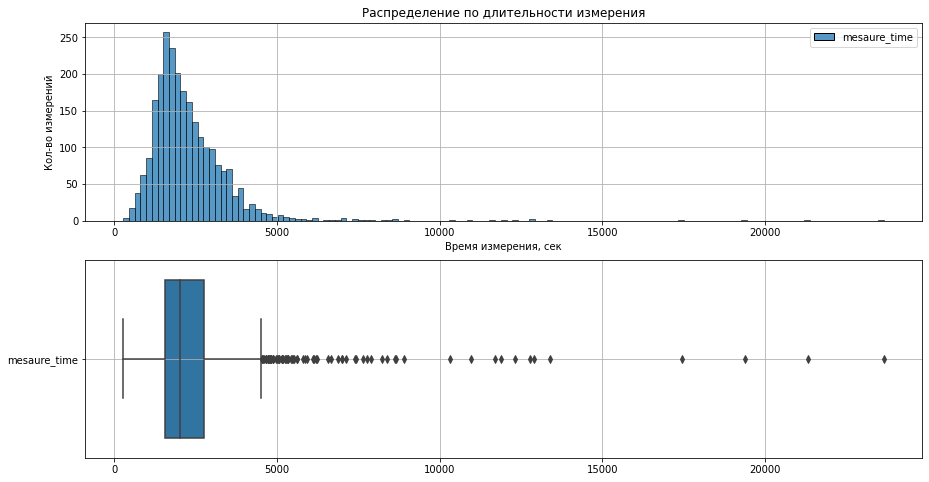

In [66]:
# Посмотрим на распределение по длительности измерения:

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sns.histplot(data=data_temp_gr[['mesaure_time']])
plt.title('Распределение по длительности измерения')
plt.xlabel('Время измерения, сек')
plt.ylabel('Кол-во измерений')
plt.grid()
plt.subplot(2,1,2)
sns.boxplot(data=data_temp_gr[['mesaure_time']], orient='horizontal')
plt.grid()
plt.show()

In [67]:
data_temp_gr.describe()

,start_temp,finish_temp,iter_num_y,mesaure_time
count,2475.000000,2475.000000,2475.000000,2475.000000
mean,1589.029899,1595.336162,5.624242,2279.871111
std,24.998058,16.023153,1.610965,1373.958293
min,1519.000000,1541.000000,2.000000,270.000000
25%,1572.000000,1587.000000,5.000000,1544.500000
50%,1588.000000,1593.000000,5.000000,2006.000000
75%,1605.000000,1599.000000,7.000000,2738.500000
max,1679.000000,1700.000000,17.000000,23674.000000


Более чем в 75 % время замера укладывается в 2739 секунд, средняя продолжительность замера примерно 2280. Аномально выглядят замеры свыше 10000 сек.

In [68]:
data_temp_gr.query('mesaure_time > 10000')

,start_time_temp,finish_time_temp,start_temp,finish_temp,iter_num_y,mesaure_time
key,,,,,,
44,2019-05-04 23:26:23,2019-05-05 02:29:19,1600.0,1603.0,13,10976.0
46,2019-05-05 03:52:46,2019-05-05 07:18:09,1607.0,1612.0,14,12323.0
118,2019-05-07 22:57:25,2019-05-08 01:49:24,1652.0,1600.0,7,10319.0
638,2019-05-27 17:46:42,2019-05-27 21:30:10,1588.0,1619.0,12,13408.0
641,2019-05-28 03:43:37,2019-05-28 08:34:44,1617.0,1580.0,7,17467.0
801,2019-06-03 14:47:07,2019-06-03 18:22:02,1638.0,1582.0,8,12895.0
1513,2019-06-29 05:41:20,2019-06-29 08:56:12,1553.0,1574.0,16,11692.0
1689,2019-07-05 08:07:11,2019-07-05 14:41:45,1583.0,1606.0,16,23674.0
1880,2019-07-12 07:04:51,2019-07-12 10:22:58,1606.0,1615.0,12,11887.0


Большое значение времени замера обусловленно большим кол-вом итераций в партии. В максимуме доходит до 6 часов. Скорее всего это связанно с обработкой редких сплавов.

Посмотрим какое колч-во партий в таблице имеет ананомальную температуру свыше 5000 сек.

In [69]:
data_temp_gr.query('mesaure_time > 5000').count()

start_time_temp     54
finish_time_temp    54
start_temp          54
finish_temp         54
iter_num_y          54
mesaure_time        54
dtype: int64

54 партии имеют значения свыше 5000 сек. Что составляет примерно 2 % объема от кол-ва оставшихся партий. ~~Для улучшения итогового результата (приняв их за выбросы) отбросим партии с продолжительностью времени замера свыше 5000 сек.~

In [70]:
#data_temp_gr = data_temp_gr.query('mesaure_time < 5000')

In [71]:
data_temp_gr = data_temp_gr.drop('iter_num_y', axis=1)

In [72]:
data_temp_gr

,start_time_temp,finish_time_temp,start_temp,finish_temp,mesaure_time
key,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536.0
...,...,...,...,...,...
2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,1380.0
2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,1705.0
2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,962.0


***Вывод:***  

- Привели названия столбцов к стандарту PEP8 и данные к соответствующему им типу;
- Из изначального датасета выделены начальное и конечное время замера температуры(`start_time_temp`,`finish_time_temp`), а так же начальное и конечное значение температуры при замере(`start_temp`,`finish_temp`). Так же в отдельный столбец выведено значение прдолжительности замера для партии `mesaure_time`.
- Исходя из условий заказчика о том, , что значения температуры ниже 1500 °C — аномальные.  
Отобрали только те данные которые свыше 1500 °C:
- Исходя из тех же условий о том что у каждой партии должно быть начальное и конечное время замера, были выявленны партии где значения этих замеров совпадали с точностью до секунды. Данные партии имели всего одну итерацию. Всего таких записей/партий 740. Эти данные не полные. Восстановить их нет возможности. Данные были исключены из датасета.
- При анализе длительности измерения температуры были выявлены выбросы. Эти данные так же исключили из датасета.

### Таблица данных об объёме проволочных материалов

**Таблица** `data_wire`
   - `key` — номер партии;
   - `Wire1` … `Wire15` — объём подаваемых проволочных материалов.

In [73]:
query = '''

SELECT *
FROM data_wire

'''

data_wire = pd.read_sql_query(query, con=engine) 
display(data_wire)
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,None,None,None,None,None,None,None,None
3077,3238,56.128799,None,None,None,None,None,None,None,None
3078,3239,143.357761,None,None,None,None,None,None,None,None
3079,3240,34.070400,None,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


- Датасет содержит 3080 записей (кол-во записей ниже кол-ва партий - 3241), присутствуют пропуски данных ввиде и `None`;
- Столбцы имею некорректный тип данных `object` вместо `float`.

Приведем названия столбцов в соответствие с PEP8.

In [74]:
data_wire.columns = [x.replace(' ','_').lower() for x in  data_wire.columns]
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


In [75]:
columns(data_wire)

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [76]:
print('Кол-во дубликатов:', data_wire['key'].duplicated().sum())

Кол-во дубликатов: 0


In [77]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Проволочный материал №5 применили только в одном случае, материал №1 применяли практически всегда, также достаточно часто (более чем для трети партий) применялся материал №2, остальные материалы применялись от 11 до 63 раз.

Посмотрим, какую долю от общего числа составляют пропущенные значения:

In [78]:
data_wire.isna().sum()/data_wire.shape[0]

key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

Уберем колонки, где доля пропущенных значений более 95%:

In [79]:
cols = data_wire.columns
for c in cols:
    if data_wire[c].isna().sum() / data_wire.shape[0] > 0.95:
        data_wire = data_wire.drop(c, axis=1)

Заменим пропуски на нули, тк пропуск обозначает, что материал не добавляли в эту партию.

In [80]:
data_wire = data_wire.fillna(0)

In [81]:
data_wire_gr = data_wire.set_index('key')

data_wire_gr

,wire_1,wire_2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456
...,...,...
3237,38.088959,0.00000
3238,56.128799,0.00000
3239,143.357761,0.00000


***Вывод:***
- Датасет содержит 3080 записей (кол-во записей ниже кол-ва партий - 3241);
- Привели названия столбцов к стандарту PEP8 и данные к соответствующему им типу;
- Проволочный материал №5 применили только в одном случае, материал №1 применяли практически всегда, также достаточно часто (более чем для трети партий) применялся материал №2, остальные материалы применялись от 11 до 63 раз;
- Избавились от столбцов с долей пропущенных значений > 95%.

### Таблица данных о времени подачи проволочных материалов

**Таблица** `data_wire_time`
   - `key` — номер партии;
   - `Wire1` … `Wire15` — время подачи проволочных материалов.

In [82]:
query = '''

SELECT *
FROM data_wire_time

'''

data_wire_time = pd.read_sql_query(query, con=engine) 
display(data_wire_time)
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,None,None,None,None,None,None,None,None
3077,3238,2019-09-06 12:18:35,None,None,None,None,None,None,None,None
3078,3239,2019-09-06 14:36:11,None,None,None,None,None,None,None,None
3079,3240,2019-09-06 15:33:55,None,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


- Датасет содержит 3080 записей (кол-во записей ниже кол-ва партий - 3241);
- Привести названия столбцов к стандарту PEP8 и данные к соответствующему им типу;

Приведем названия столбцов в соответствие с PEP8.

In [83]:
data_wire_time.columns = [x.replace(' ','_').lower() for x in  data_wire_time.columns]
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


In [84]:
print('Кол-во дубликатов:', data_wire_time['key'].duplicated().sum())

Кол-во дубликатов: 0


In [85]:
data_wire_time = data_wire_time.set_index('key')

Преобразуем время в формат datetime:

In [86]:
for i in range(1,10):
    data_wire_time['wire_' + str(i)] = pd.to_datetime(data_wire_time['wire_' + str(i)])

In [87]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wire_1  3055 non-null   datetime64[ns]
 1   wire_2  1079 non-null   datetime64[ns]
 2   wire_3  63 non-null     datetime64[ns]
 3   wire_4  14 non-null     datetime64[ns]
 4   wire_5  1 non-null      datetime64[ns]
 5   wire_6  73 non-null     datetime64[ns]
 6   wire_7  11 non-null     datetime64[ns]
 7   wire_8  19 non-null     datetime64[ns]
 8   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


In [88]:
# Рассчитаем столбцы с временем начала добавления сыпучих материалов, окончания и длительности процесса:

data_wire_time['start_time_wire'] = data_wire_time.min(axis=1)
data_wire_time['finish_time_wire'] = data_wire_time.max(axis=1)
data_wire_time['duration_wire'] = (data_wire_time['finish_time_wire'] - data_wire_time['start_time_wire']
                                  ).astype('timedelta64[s]')

In [89]:
data_wire_time

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,start_time_wire,finish_time_wire,duration_wire
key,,,,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:33:38,2019-09-06 11:33:38,0.0
3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,2019-09-06 12:18:35,0.0
3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 14:36:11,2019-09-06 14:36:11,0.0


Оставим только рассчитанные столбцы:

In [90]:
# Оставим только рассчитанные столбцы:

data_wire_time = data_wire_time[['start_time_wire', 'finish_time_wire','duration_wire']]

In [91]:
data_wire_time.describe()

,duration_wire
count,3081.000000
mean,214.519312
std,396.131967
min,0.000000
25%,0.000000
50%,0.000000
75%,401.000000
max,5937.000000


In [92]:
data_wire_time.describe(include='datetime')

,start_time_wire,finish_time_wire
count,3081,3081
unique,3081,3081
top,2019-08-17 06:50:00,2019-07-28 01:17:01
freq,1,1
first,2019-05-03 11:06:19,2019-05-03 11:06:19
last,2019-09-06 17:10:06,2019-09-06 17:10:06


Время добавления проволочных материалов находится в тех же промежутках, что и ранее рассмотренные данные по обработке стали. Длительность обработок с использованием проволочных материалов выглядят корректным, максимальная длительность обработки одной партии составляет 5937 сек (чуть больше 1.5 часов)

Данные по времени подачи проволочных материалов можно не использовать. Такие данные нужны, чтобы подтвердить, что технологический процесс выполняется корректно и по времени.

***Вывод:***
- Датасет содержит 3129 записей (кол-во записей ниже кол-ва партий - 3241);
- Проведен анализ времени добавления проволочных материалов. Время добавления проволочных материалов находится в тех же промежутках, что и ранее рассмотренные данные по обработке стали;
- Данные о времени подачи проволочных материалов были нужны для подтверждения корректности тех. процесса по времени.

### Объединение таблиц

In [93]:
df = data_arc_gr.merge(data_gas_gr, on='key', how='inner')
df = df.merge(data_temp_gr, on='key', how='inner')
df = df.merge(data_bulk_gr, on='key', how='inner')
df = df.merge(data_wire_gr, on='key', how='inner')
df

,key,iter_num,begin_heat,end_heat,active_power,reactive_power,heat_time,total_power,power_coef,gas,...,start_temp,finish_temp,mesaure_time,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,3.036730,2.142821,1098.0,3.718736,4.083428,29.749986,...,1571.0,1613.0,1714.0,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000
1,2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,2.139408,1.453357,811.0,2.588349,3.301105,12.555561,...,1581.0,1602.0,1265.0,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000
2,3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,4.063641,2.937457,655.0,5.019223,4.048621,28.554793,...,1596.0,1599.0,1753.0,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000
3,4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,2.706489,2.056992,741.0,3.400038,3.175691,18.841219,...,1601.0,1625.0,1220.0,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000
4,5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,2.252950,1.687991,869.0,2.816980,3.187274,5.413692,...,1576.0,1602.0,1536.0,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,4,2019-08-10 11:27:57,2019-08-10 11:48:05,3.168133,2.210936,723.0,3.868721,3.250906,7.125735,...,1570.0,1591.0,1380.0,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000
2325,2496,6,2019-08-10 11:56:58,2019-08-10 12:23:07,4.174918,2.872031,940.0,5.070316,4.917636,9.412616,...,1554.0,1591.0,1705.0,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000
2326,2497,3,2019-08-10 12:37:36,2019-08-10 12:51:20,3.605239,2.452092,569.0,4.360918,2.482839,6.271699,...,1571.0,1589.0,962.0,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800
2327,2498,5,2019-08-10 12:58:21,2019-08-10 13:20:59,3.202310,2.239820,750.0,3.909917,4.096223,14.953657,...,1591.0,1594.0,1520.0,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000


### Исследовательский анализ данных объедененной таблицы

Время замера конечной температуры должен быть самым последним значением даты-времени для данной партии, проверим это условие

In [94]:
date_columns = df.select_dtypes('datetime').columns
date_columns

Index(['begin_heat', 'end_heat', 'start_time_temp', 'finish_time_temp'], dtype='object')

In [95]:
df['is_finish_time_temp_last'] = (df['finish_time_temp'] >= df[date_columns].max(axis=1)).astype(int)

In [96]:
df[df['is_finish_time_temp_last'] == 0][date_columns]

,begin_heat,end_heat,start_time_temp,finish_time_temp


Собранный датасет удовлетворяет условию.  

Признаки связанные с проверкой условия больше не нужны:

In [97]:
df = df.drop(date_columns, axis=1)
df = df.drop('is_finish_time_temp_last', axis=1)

In [98]:
df.head()

,key,iter_num,active_power,reactive_power,heat_time,total_power,power_coef,gas,start_temp,finish_temp,mesaure_time,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,5,3.036730,2.142821,1098.0,3.718736,4.083428,29.749986,1571.0,1613.0,1714.0,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000
1,2,4,2.139408,1.453357,811.0,2.588349,3.301105,12.555561,1581.0,1602.0,1265.0,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000
2,3,5,4.063641,2.937457,655.0,5.019223,4.048621,28.554793,1596.0,1599.0,1753.0,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000
3,4,4,2.706489,2.056992,741.0,3.400038,3.175691,18.841219,1601.0,1625.0,1220.0,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000
4,5,4,2.252950,1.687991,869.0,2.816980,3.187274,5.413692,1576.0,1602.0,1536.0,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2329 non-null   int64  
 1   iter_num        2329 non-null   int64  
 2   active_power    2329 non-null   float64
 3   reactive_power  2329 non-null   float64
 4   heat_time       2329 non-null   float64
 5   total_power     2329 non-null   float64
 6   power_coef      2329 non-null   float64
 7   gas             2329 non-null   float64
 8   start_temp      2329 non-null   float64
 9   finish_temp     2329 non-null   float64
 10  mesaure_time    2329 non-null   float64
 11  bulk_3          2329 non-null   float64
 12  bulk_4          2329 non-null   float64
 13  bulk_12         2329 non-null   float64
 14  bulk_14         2329 non-null   float64
 15  bulk_15         2329 non-null   float64
 16  wire_1          2329 non-null   float64
 17  wire_2          2329 non-null   f

Итоговая таблица содержит 2278 записей и 16 столбцов

Посмотрим также на признаки сильнее всего коррелирующие с целевым признаком:

In [100]:
corr_target=pd.Series()
for col in df.columns:
    corr_target[col] = df['finish_temp'].corr(df[col])
corr_target= corr_target.sort_values(ascending=False)[1:]

/tmp/ipykernel_461/1890563255.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_target=pd.Series()


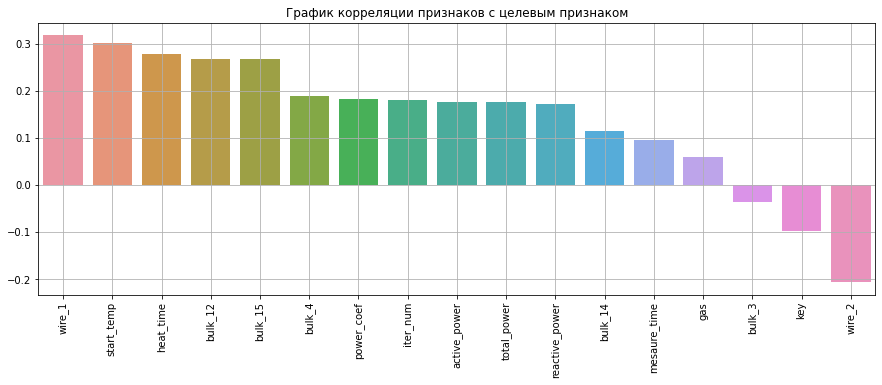

In [101]:
plt.figure(figsize=(15,5))
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.title('График корреляции признаков с целевым признаком')
plt.grid()
plt.xticks(rotation=90)
plt.show()

Факторов по отдельности сильно коррелирующих с таргетом нет:
- максимальная корреляция наблюдается в районе 0,35 с начальной температурой;
- проволочными материалами № 1; сыпучими материалами № 12,15 и некоторыми характеристиками подготовки на этапе нагрева электродами

Посмотрим на взаимосвязь признаков:

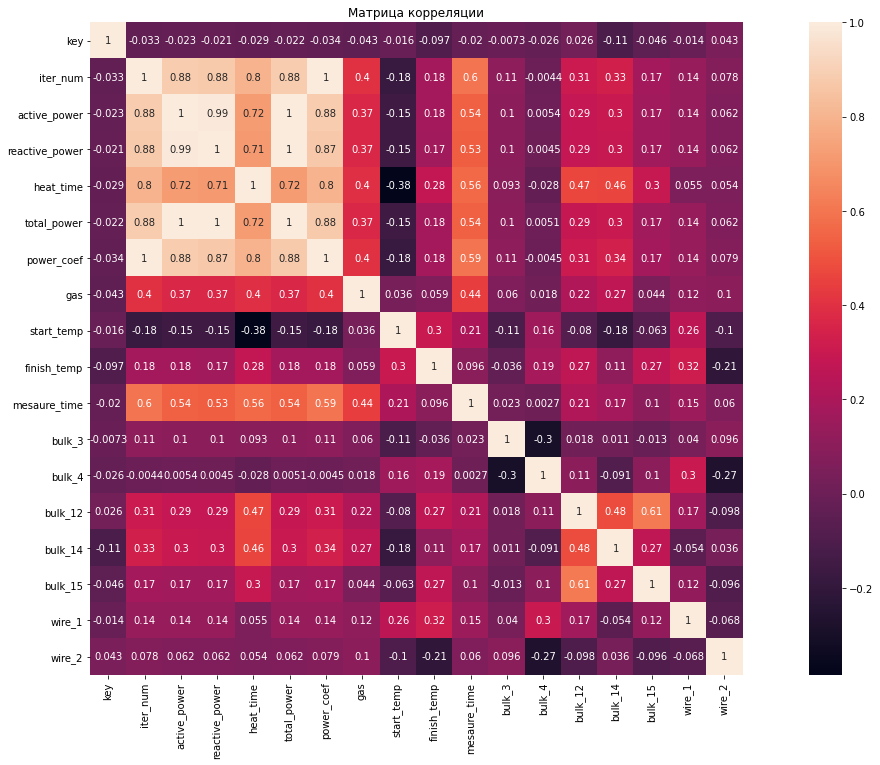

In [102]:
plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),vmax=1,square=True,annot=True);
plt.title('Матрица корреляции');

- Высокая корреляция наблюдается между характеристиками электродов (количество итераций партии и активная, реактивная, мощность, а так же продолжительность нагрева). 
- Некоторые сыпучие и проволочные материалы вероятно используют чаще всего вместе и в коррелирующих пропорциях.
- Удалим кол-во итераций, тк признаки активная, реактивная, мощность, а так же продолжительность нагрева напрямую зависят от нее. В ходе обучения и тестирования моделей значение MAE улучшилось.
- наблюдается мультиколлинеарность для признаков активной и реактивной мощности, а также времени нагрева и полной мощности. Удалим признаки мощностей, тк для них мы уже вычислили коэффициент:

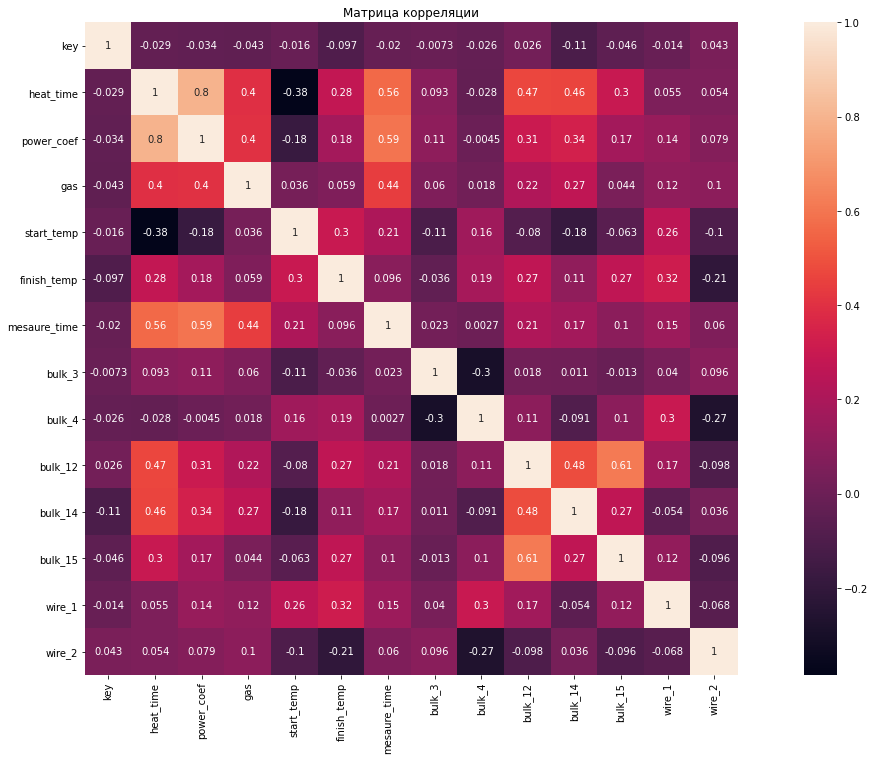

In [103]:
df = df.drop(['iter_num', 'total_power', 'active_power', 'reactive_power'], axis=1)

plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),vmax=1,square=True,annot=True);
plt.title('Матрица корреляции');

Из тепловой карты видим, что в наибольшей степени конечная температура `finish_temp` зависит от:

- начальной температуры
- продолжительности нагрева
- объема подаваемых проволочных и сыпучих материалов
- Посмотрим на итоговое распределение признаков:

 Посмотрим на итоговые распределения признаков, исследованных и отобранных на этапах 2.1 - 2.7:

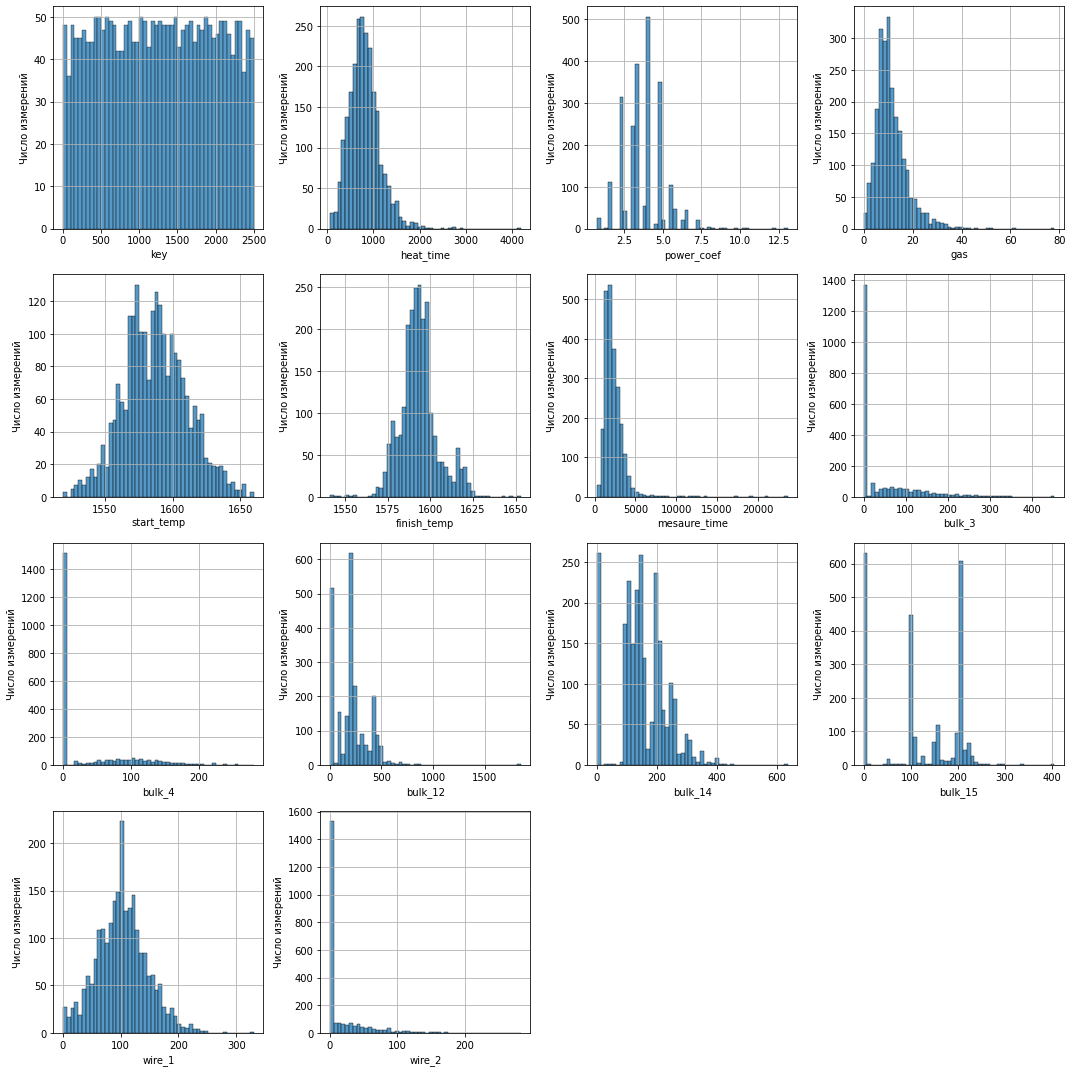

In [104]:
cols = df.columns

fig = plt.figure(figsize=(15,15))
for i in range(len(cols)):
    fig.add_subplot(4, 4, i+1)
    sns.histplot(df[cols[i]], bins=50)
    plt.ylabel('Число измерений') 
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True);    

## Обучение моделей

### Разделение на выборки

In [105]:
# Разделяем данные на тренировочную и тестовую выборки (test_size = 0.25), выделив целевой признак:

x_train, x_test, y_train, y_test = train_test_split(df.drop('finish_temp', axis=1), 
                                                    df['finish_temp'], test_size=0.25, 
                                                    random_state=RANDOM_STATE)

In [106]:
# Смотрим размеры выборок:
for i in [x_train, y_train, x_test, y_test]:
    print(i.shape)

(1746, 13)
(1746,)
(583, 13)
(583,)


Удаляем статистические выбросы из обучающей выборки, чтобы получить тестувую выборку без подгонки под хороший результат. 

In [107]:
data_train = pd.concat((x_train, y_train), axis=1)

data_train = data_train.query('mesaure_time < 5000')

x_train, y_train = data_train.drop('finish_temp', axis=1), data_train['finish_temp']

In [108]:
# Проводим масштабирование  данных:
scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [109]:
# Смотрим размеры выборок:
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(1708, 13)
(1708,)
(583, 13)
(583,)


In [110]:
# Функция для поиска оптимальных параметров:
def rs_cv(model, params):
    rs_cv = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, cv=5)
    rs_cv.fit(X_train, y_train)
    best_score_mae = round(rs_cv.best_score_*-1, 3)
    
    #rs_cv = RandomizedSearchCV(model,
    #param_distributions=params, 
    #scoring='r2', 
    #n_jobs=-1, cv=5)
    #rs_cv.fit(X_train, y_train)
    #best_score_r2 = round(rs_cv.best_score_, 3)
    y_train_pred = rs_cv.predict(X_train)
    best_score_r2 = round(r2_score(y_train, y_train_pred),3)
    
    print('MAE на обучающей выборке:± {:.3f}°C'.format(best_score_mae) )
    print('R2 на обучающей выборке:', best_score_r2)
    print('----------------------')
    print('Oптимальные параметры:\n', rs_cv.best_params_)
    return best_score_mae, best_score_r2, rs_cv.best_estimator_

### Линейная регрессия - LinearRegression

In [111]:
params =  {}

mae_lr, r2_lr, model_lr = rs_cv(LinearRegression(), params)

MAE на обучающей выборке:± 5.796°C
R2 на обучающей выборке: 0.504
----------------------
Oптимальные параметры:
 {}


### Дерево решений

In [112]:
params =  {'max_depth': range (1,13, 2),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}

mae_dt, r2_dt, model_dt = rs_cv(DecisionTreeRegressor(random_state=RANDOM_STATE), params)

MAE на обучающей выборке:± 6.886°C
R2 на обучающей выборке: 0.468
----------------------
Oптимальные параметры:
 {'min_samples_split': 8, 'min_samples_leaf': 7, 'max_depth': 5}


### Случайный лес

In [113]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}
           
mae_rf, r2_rf, model_rf = rs_cv(RandomForestRegressor(random_state=RANDOM_STATE), params)

MAE на обучающей выборке:± 5.838°C
R2 на обучающей выборке: 0.831
----------------------
Oптимальные параметры:
 {'n_estimators': 115, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 12}


### CatBoost

In [114]:
params =  {'depth': range (4,10)}
           
mae_cb, r2_cb, model_cb = rs_cv(CatBoostRegressor(random_state=RANDOM_STATE, verbose=False), params)

MAE на обучающей выборке:± 5.610°C
R2 на обучающей выборке: 0.832
----------------------
Oптимальные параметры:
 {'depth': 4}


### LightGBM

In [115]:
params =  {'max_depth': range (4,15),
          'n_estimators': range(10, 155, 15) }
           
mae_lgbm, r2_lgbm, model_lb = rs_cv(LGBMRegressor(random_state=RANDOM_STATE), params)

MAE на обучающей выборке:± 5.703°C
R2 на обучающей выборке: 0.815
----------------------
Oптимальные параметры:
 {'n_estimators': 115, 'max_depth': 5}


### Torch

In [116]:
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.values)#.reshape(-1, 1)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test.values)#.reshape(-1, 1)

In [117]:
# Объявим класс EarlyStopping, 
# который будет предотвращать переобучение и останавливать цикл обучения по достижению оптимального значения

class EarlyStopping():
    def __init__(self, patience=7, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss

            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
             self.counter += 1
                
             if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True

In [118]:
# Инициализируем нейронную сеть, состоящую из входных нейронов, двух скрытых слоев и выходного слоя:

class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)

        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.act2 = nn.Tanh()
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        
        
        #self.fc3 = nn.Linear(hidden_size2, num_classes) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3) 
        self.act3 = nn.Tanh()
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        
        
        self.fc4 = nn.Linear(hidden_size3, num_classes) 
        
        #self.bn3 = nn.BatchNorm1d(num_classes)
        
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.bn1(out)
       
        out = self.fc2(out)
        out = self.act2(out)
        out = self.bn2(out)
        #out = self.bn3(out)
        
        
        out = self.fc3(out)
        out = self.act3(out)
        out = self.bn3(out)
        
        out = self.fc4(out)

                
        return out

Обучим сеть и получим метрики:

In [119]:
n_in_neurons = X_train.shape[1]
hidden_size_1 = 150
hidden_size_2 = 75
hidden_size_3 = 35
n_out_neurons = 1                                
num_epochs = 1000
torch.manual_seed(RANDOM_STATE)

loss = nn.MSELoss() 

batch_size = 10
dataset_train = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
dataset_test = torch.utils.data.TensorDataset(X_test_torch, y_test_torch)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)  
net = Net(n_in_neurons, hidden_size_1, hidden_size_2, hidden_size_3, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=8e-5)

In [120]:
early_stopping = EarlyStopping() 
mae_torch = np.inf 
    
for epoch in tqdm(range(num_epochs)):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch  
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()

    predicted_temp = [] 
    with torch.no_grad():
        net.eval()
        for batch in test_dataloader:
            data_test, temperature_test = batch
  
            test_preds = net.forward(data_test).flatten()
            predicted_temp.append(test_preds)
            RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

    predicted_temp = torch.cat(predicted_temp).detach().numpy()
    mae = mean_absolute_error(y_test_torch.detach().numpy(), predicted_temp)
    
    if mae < mae_torch:
        mae_torch = mae
        best_epoch = epoch
        test_preds_best = predicted_temp
    early_stopping(mae)

    if early_stopping.early_stop:
        break 
mae_torch = round(mae_torch, 3)     
r2_torch = round(r2_score(y_test_torch.detach().numpy(), predicted_temp), 3)
print('MAE:', mae_torch, '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
print('R2:', r2_torch)

 48%|████▊     | 485/1000 [16:48<17:50,  2.08s/it]

Early stopping
MAE: 6.303 | ep 485 from 1000 | best_epoch: 478
R2: 0.454


### DummyRegressor

In [121]:
params =  {}

mae_dummy, r2_dummy, model_d = rs_cv(DummyRegressor(strategy='mean'), params)

MAE на обучающей выборке:± 7.696°C
R2 на обучающей выборке: 0.0
----------------------
Oптимальные параметры:
 {}


### Выбор модели

In [122]:
d={'MAE':[mae_lr, mae_dt, mae_rf, mae_cb, mae_lgbm, mae_torch, mae_dummy],
   'R2':[r2_lr, r2_dt, r2_rf, r2_cb, r2_lgbm, r2_torch, r2_dummy]}

results = pd.DataFrame(data=d, index=['LinearRegression', 
                                      'DescisionTree', 'RandomForest', 
                                      'CatBoost', 'LightGBM', 'Torch', 'DummyRegressor'])
results.sort_values(by='MAE')

,MAE,R2
CatBoost,5.610,0.832
LightGBM,5.703,0.815
LinearRegression,5.796,0.504
RandomForest,5.838,0.831
Torch,6.303,0.454
DescisionTree,6.886,0.468
DummyRegressor,7.696,0.000


Лучшее качество по метрике MAE получена для модели `CatBoost` = 5.61.

## Тестирование модели

In [123]:
predicted_test = model_cb.predict(X_test)
mae_cb_t = round(mean_absolute_error(y_test, predicted_test), 3)
r2_cb_t = round(r2_score(y_test, predicted_test), 3)

print('MAE на тестовой выборке:± {:.3f}°C'.format(mae_cb_t))
print('R2 на тестовой выборке:', r2_cb_t)

MAE на тестовой выборке:± 6.096°C
R2 на тестовой выборке: 0.489


Сравним с константной моделью:

In [124]:
predicted_test = model_d.predict(X_test)
mae_d_t = round(mean_absolute_error(y_test, predicted_test), 3)
r2_d_t = round(r2_score(y_test, predicted_test), 3)

print('MAE на тестовой выборке:± {:.3f}°C'.format(mae_d_t))
print('R2 на тестовой выборке:', r2_d_t)

MAE на тестовой выборке:± 8.557°C
R2 на тестовой выборке: -0.0


In [125]:
d={'MAE':[mae_cb_t, mae_d_t],
   'R2':[r2_cb_t, r2_d_t]}

results = pd.DataFrame(data=d, index=['CatBoostRegressor', 'DummyRegressor'])
results.sort_values(by='MAE')

,MAE,R2
CatBoostRegressor,6.096,0.489
DummyRegressor,8.557,-0.000


***Вывод:***  

**Вариант 1** - удаление выбросов из данных об измерениях температуры из всего датасета:  

 - Результат MAE модели `CatBoost` на тестовой выборке - 5.347, что удовлетворяет условию заказчика(значение метрики MAE у выбранной модели должно быть менее 6.8)  
 - Значение R2 модели на тестовой выборке - 0.519, это достаточно далеко от единицы и говорит о том, что модель может недостаточно хорошо работать с неизвестным набором данных. 
 - Модель адекватна и лучше константной.
 
**Вариант 2** - удаление статистических выбросов только из обучающей выборки (Удалять статистические выбросы заказчик хочет только в обучающей выборки. Так как уже обработаны аномалии по отрицательной мощности и температур ниже 1500, то все остальные показатели относятся к реальным значениям в процессе производства). Данный подход позволит получить тестовую выборку без подгонки под хороший результат. 

 - Результат MAE модели `CatBoost` на тестовой выборке - 6.096, что удовлетворяет условию заказчика(значение метрики MAE у выбранной модели должно быть менее 6.8)  
 - Значение R2 модели на тестовой выборке - 0.489, это достаточно далеко от единицы и говорит о том, что модель может недостаточно хорошо работать с неизвестным набором данных. 
 - Модель адекватна и лучше константной.  

Проанализируем важность основных факторов, влияющих на предсказание модели:

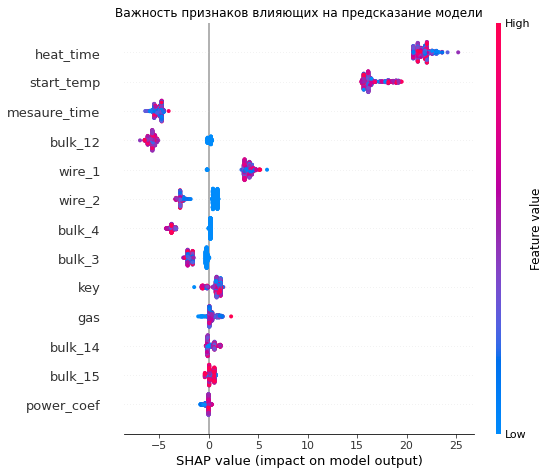

In [126]:
explainer = shap.Explainer(model_cb)
shap_values = explainer.shap_values(x_test)

plt.title('Важность признаков влияющих на предсказание модели');
shap.summary_plot(shap_values, x_test, show=False, max_display = 15)

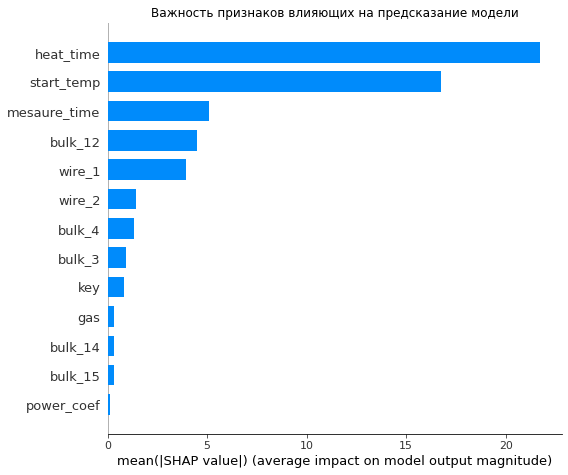

In [127]:
plt.title('Важность признаков влияющих на предсказание модели');
shap.summary_plot(shap_values, x_test, plot_type="bar", max_display = 15)

Самыми важными признакамм.
- продолжительность нагрева - `heat_time`
- начальная температура - `start_temp`
- объем подаваемых сыпучих/проволочных материалов- `bulk_12, wire_1`
- продолжительности замера температуры между первым и последним временем - `mesaure_time`

График зависимости длительности нагрева и конечной температуры.

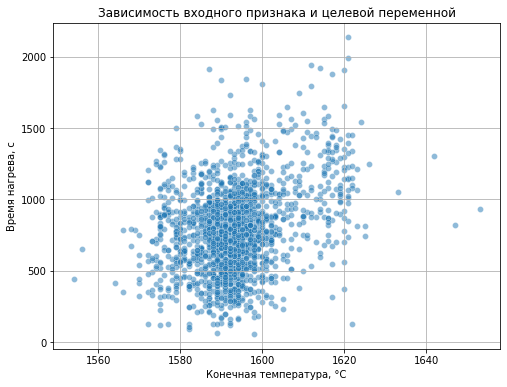

In [128]:
plt.figure(figsize=(8,6))
sns.scatterplot(y_train, x_train['heat_time'], alpha=0.5)
plt.title('Зависимость входного признака и целевой переменной')
plt.ylabel('Время нагрева, c')
plt.xlabel('Конечная температура, °C')
plt.grid(True);

## Вывод

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

- **Задача** — построить модель, которая будет предсказывать температуру стали (задача регрессии).  
- **Метрика** -  Значение метрики MAE у выбранной модели должно быть менее 6.8.


В ходе проделанной работы были выполнены:
- подключение к базе и проверка наличия интересующих таблиц;
- загрузка и преобразование данных:
    - разноязычные названия столбцов;
    - разный тип данных;
    - пропуски в таблицах;
    - некорректные значения в партиях/
- исследование признаков в таблицах:
    - добавлены новые признаки;
    - от некоторых пришлось отказаться на этапе обучения моделей(таких как:
        - Наблюдалась мультиколлинеарность данных признаков мощности. Для этого был введен новый признак заменяющий их - коэфициент мощности.
        - использование признака кол-ва итерации приводило к мультиколлинеарности. И как следствие ухудшению метрики качества. Принято решение исключить признак);
    - на этапе исследования были выявлены неполные данные(в 740 партиях время начала нагрева и время окончания нагрева полностью совпадало). Данные были исключены из датасета;
    - Так же были выявлены как выбросы 54 партии имеющие большое кол-во итераций и соответственно большое время продолжительности нагрева. Возможно это обработка каких-то сложных сплавов. Избавились от статистических выбросов в обучающей выборке, для получения тестовою выборки без подгонки под хороший результат.
    - при проведении анализа времени добавления сыпучих/проволочных материалов была проверена корректность тех.процесса по времени. Время добавления сыпучих/проволочных материалов находится в тех же промежутках, что и ранее рассмотренные данные по обработке стали. 
- объединение таблиц:
    - произведен анализ корректности временных рамок;
    - исследованы корреляции признаков с целевым признаком, а так же между собой.
- разделение данных на обучающую и тестовую выборки в соотношении 3:1;
- обучение моделей и выбор лучшей:
    - LinearRegression;
    - DecisionTreeRegressor;
    - RandomForestRegressor;
    - CatBoostRegressor;
    - LGBMRegressor;
    - Torch.
    По итогам лучшей моделью была выбрана модель `CatBoost` показавшая лучшие метрики MAE и R2.

- проверена работа выбранной модели на тестовой выборке:
    - Результат MAE модели `CatBoost` на тестовой выборке - 6.096, что удовлетворяет условию заказчика(значение метрики MAE у выбранной модели должно быть менее 6.8)
    - Значение R2 модели на тестовой выборке - 0.489, это достаточно далеко от единицы и говорит о том, что модель может недостаточно хорошо работать с неизвестным набором данных. 
    - Модель адекватна и лучше константной.
    - Признаки, наиболее влияющие на прогноз модели  
     - продолжительность нагрева - `heat_time`
     - начальная температура - `start_temp`
     - объем подаваемых сыпучих/проволочных материалов- `bulk_12, wire_1`
     - продолжительности замера температуры между первым и последним временем - `mesaure_time`
 
Улучшение качества метрики возможно путем более тщательного подбора гиперпараметров модели 
 
 
Главными проблемами для проведенного исследования являются:
 - малый объем данных - 2300 записей/строк может быть недостаточно для точного прогноза.
 - большое число выбросов, пропусков в данных, а также неполнота данных, что негативно сказывается на прогнозе
